#### Read files from [NCI-ALMANAC](https://discover.nci.nih.gov/rsconnect/cellminercdb/), include:

- Compound 2D structure: ComboCompoundSet.sdf

- Compound chemical names: ComboCompoundNames_small.txt, ComboCompoundNames_all.txt

- Growth Inhibition Data: ComboDrugGrowth_Nov2017.csv

- Documentation: ALMANAC_DataFields.txt / ALMANAC Data Fields.docx

- Combo Scores: data_NCI60-DTP Almanac_act.txt

In [1]:
# Get the drug sample numbers and names:

import pandas as pd

# Path to your text file
txt_file_path = "/nfs/turbo/med-kayvan-lab/Projects/DrugCombination/b-DrugCombination/DC_Data/NCI-ALMANAC/ComboCompoundNames_small.txt"

# Read the text file into a DataFrame
df = pd.read_csv(txt_file_path, delimiter='\t')

# Display the DataFrame
print(df.info())
print(df.head())
print(df.tail())

# # Save the DataFrame to a CSV file
# df.to_csv('NSC_DrugName.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NSC     108 non-null    int64 
 1   Name    108 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.8+ KB
None
   NSC            Name
0  740    Methotrexate
1  750        Busulfan
2  752     Thioguanine
3  752   6-Thioguanine
4  755  Mercaptopurine
        NSC                     Name
103  761431              vemurafenib
104  707389        Eribulin mesylate
105  737754  Pazopanib hydrochloride
106  753082              vemurafenib
107  763371              Ruxolitinib


In [2]:
## There are three '#' values assigned to different 'Name's that are the same,
## Align each of the 'Name's with ' / '.
import pandas as pd

# Find the count of each value in the column
count_series = df['NSC'].value_counts()

# Filter the count series to find the repeated numbers
repeated_numbers = count_series[count_series > 1]

print("Repeated numbers:")
print(repeated_numbers)

# Define a custom function to join the content with " / "
def merge_content(group):
    return ' / '.join(group)

# Group by 'Numbers' and aggregate 'Content' using the custom function
merged_df = df.groupby('NSC')['Name'].agg(merge_content).reset_index()

print(merged_df)

# # Save the DataFrame to a CSV file
# merged_df.to_csv('NSC_DrugName.csv', index=False)

Repeated numbers:
NSC
49842    2
752      2
24559    2
Name: count, dtype: int64
        NSC                           Name
0       740                   Methotrexate
1       750                       Busulfan
2       752    Thioguanine / 6-Thioguanine
3       755                 Mercaptopurine
4       762  Mechlorethamine hydrochloride
..      ...                            ...
100  757441                       Axitinib
101  760766                     Vandetanib
102  761431                    vemurafenib
103  761432                    Cabazitaxel
104  763371                    Ruxolitinib

[105 rows x 2 columns]


In [3]:
## There are 2 same 'Name's assigned to two different '#'.
## I don't know which one should be eliminated because, for the 2D structure sdf file, there are no matching '#'s.
## Moming: vemurafenib: 761431(Molecule 102)/753082(delete); Molecule 40: 119875 Cisplatin; Molecule 57: 266046 Oxaliplatin;
import pandas as pd

# Find duplicate values in the "Name" column
duplicates = merged_df[merged_df.duplicated(subset=['Name'], keep=False)]

# Group the duplicate values by the "Name" column and display the '#' values
duplicate_groups = duplicates.groupby('Name')['NSC'].apply(list)
print(duplicate_groups)

Name
vemurafenib    [753082, 761431]
Name: NSC, dtype: object


In [4]:
# Delete duplicate (753082) and invalid molecules (Molecule 40: 119875; Molecule 57: 266046)

# List of indices to delete
indices_to_delete = [753082, 119875, 266046]

# Filter the dataframe to exclude the rows with the specified indices
cleaned_df = merged_df[~merged_df['NSC'].isin(indices_to_delete)]

# Reset the index after removing rows
cleaned_df.reset_index(drop=True, inplace=True)

print(cleaned_df)

# Save the DataFrame to a CSV file
cleaned_df.to_csv('NSC_DrugName.csv', index=False)

        NSC                           Name
0       740                   Methotrexate
1       750                       Busulfan
2       752    Thioguanine / 6-Thioguanine
3       755                 Mercaptopurine
4       762  Mechlorethamine hydrochloride
..      ...                            ...
97   757441                       Axitinib
98   760766                     Vandetanib
99   761431                    vemurafenib
100  761432                    Cabazitaxel
101  763371                    Ruxolitinib

[102 rows x 2 columns]


In [5]:
# Read the Compound 2D structure: ComboCompoundSet.sdf file

import pandas as pd
from rdkit import Chem

# Path to your SDF file
sdf_file_path = "/nfs/turbo/med-kayvan-lab/Projects/DrugCombination/b-DrugCombination/DC_Data/NCI-ALMANAC/ComboCompoundSet.sdf"

# Read the SDF file
suppl = Chem.SDMolSupplier(sdf_file_path)

# Create lists to store valid SMILES and molecule IDs
valid_smiles = []
mol_ids = []

# Iterate over the molecules in the SDF file
for idx, mol in enumerate(suppl, start=1):
    if mol is not None:
        try:
            # Try to sanitize the molecule
            Chem.SanitizeMol(mol)
            # If successful, process the molecule
            # Append its SMILES representation and molecule ID to the lists
            valid_smiles.append(Chem.MolToSmiles(mol))
            mol_ids.append(idx)
            print(f"Molecule {idx}: {Chem.MolToSmiles(mol)}")
        except Exception as e:
            # If an error occurs during sanitization, skip the molecule and print the error
            print(f"Error processing molecule {idx}: {e}")

# Create a DataFrame from the valid SMILES and molecule IDs
df = pd.DataFrame({"Molecule_ID": mol_ids, "SMILES": valid_smiles})

# Save the DataFrame to a CSV file
df.to_csv("valid_molecules.csv", index=False)

Molecule 1: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1
Molecule 2: CS(=O)(=O)OCCCCOS(C)(=O)=O
Molecule 3: Nc1nc(=S)c2[nH]cnc2[nH]1
Molecule 4: S=c1nc[nH]c2nc[nH]c12
Molecule 5: CN(CCCl)CCCl.Cl
Molecule 6: O=c1[nH]cnc2[nH]ncc12
Molecule 7: Cc1c2oc3c(C)ccc(C(=O)N[C@@H]4C(=O)N[C@H](C(C)C)C(=O)N5CCC[C@H]5C(=O)N(C)CC(=O)N(C)[C@@H](C(C)C)C(=O)O[C@H]4C)c3nc-2c(C(=O)N[C@@H]2C(=O)N[C@H](C(C)C)C(=O)N3CCC[C@H]3C(=O)N(C)CC(=O)N(C)[C@@H](C(C)C)C(=O)O[C@H]2C)c(N)c1=O
Molecule 8: O=C(O)CCCc1ccc(N(CCCl)CCCl)cc1
Molecule 9: S=P(N1CC1)(N1CC1)N1CC1
Molecule 10: Cl.N[C@@H](Cc1ccc(N(CCCl)CCCl)cc1)C(=O)O
Molecule 11: C1CN1c1nc(N2CC2)nc(N2CC2)n1
Molecule 12: CN(C)c1nc(N(C)C)nc(N(C)C)n1
Molecule 13: CCN(CC)CCCC(C)Nc1c2ccc(Cl)cc2nc2ccc(OC)cc12.Cl
Molecule 14: Cl.NCC(=O)CCC(=O)O
Molecule 15: O=c1[nH]cc(F)c(=O)[nH]1
Molecule 16: CO[C@H](C(=O)[C@@H](O)[C@@H](C)O)[C@@H]1Cc2cc3cc(OC4CC(OC5CC(O)C(O)C(C)O5)C(O)C(C)O4)c(C)c(O)c3c(O)c2C(=O)[C@H]1OC1CC(OC2CC(OC3CC(C)(O)C(O)C(C)O3)C(O)C(C)O2)C(O)C(C)

[10:34:07] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[10:34:07] ERROR: Could not sanitize molecule ending on line 6200
[10:34:07] ERROR: Explicit valence for atom # 0 Cl, 2, is greater than permitted
[10:34:07] Explicit valence for atom # 3 O, 3, is greater than permitted
[10:34:07] ERROR: Could not sanitize molecule ending on line 8652
[10:34:07] ERROR: Explicit valence for atom # 3 O, 3, is greater than permitted


In [6]:
# Combine "NSC_DrugName.csv" and "valid_molecules.csv"
import pandas as pd

# Read DrugNSC.csv into a DataFrame
drug_df = pd.read_csv("NSC_DrugName.csv")

# Read valid_molecules.csv into a DataFrame
molecule_df = pd.read_csv("valid_molecules.csv")

# Assuming molecule_df contains a column named 'SMILES', concatenate it with drug_df
combined_df = pd.concat([drug_df, molecule_df['SMILES']], axis=1)
print(combined_df)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("NSC_DrugName_SMILES.csv", index=False)

        NSC                           Name  \
0       740                   Methotrexate   
1       750                       Busulfan   
2       752    Thioguanine / 6-Thioguanine   
3       755                 Mercaptopurine   
4       762  Mechlorethamine hydrochloride   
..      ...                            ...   
97   757441                       Axitinib   
98   760766                     Vandetanib   
99   761431                    vemurafenib   
100  761432                    Cabazitaxel   
101  763371                    Ruxolitinib   

                                                SMILES  
0    CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CC...  
1                           CS(=O)(=O)OCCCCOS(C)(=O)=O  
2                             Nc1nc(=S)c2[nH]cnc2[nH]1  
3                                S=c1nc[nH]c2nc[nH]c12  
4                                      CN(CCCl)CCCl.Cl  
..                                                 ...  
97     CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[n

In [7]:
# Read the Growth Inhibition Data: ComboDrugGrowth_Nov2017.csv file

import pandas as pd

# Path to your CSV file
csv_file_path = "/nfs/turbo/med-kayvan-lab/Projects/DrugCombination/b-DrugCombination/DC_Data/NCI-ALMANAC/ComboDrugGrowth_Nov2017.csv"

# Read the CSV file
combo_druggrowth_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to verify the data has been read correctly
print(combo_druggrowth_df.info())
# print(combo_druggrowth_df.head())
# print(combo_druggrowth_df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   COMBODRUGSEQ       1048575 non-null  int64  
 1   SCREENER           1048575 non-null  object 
 2   STUDY              1048575 non-null  object 
 3   TESTDATE           1048575 non-null  object 
 4   PLATE              1048575 non-null  object 
 5   PANELNBR           1048575 non-null  int64  
 6   CELLNBR            1048575 non-null  int64  
 7   PREFIX1            1048575 non-null  object 
 8   NSC1               1048575 non-null  int64  
 9   SAMPLE1            1048575 non-null  int64  
 10  CONCINDEX1         1048575 non-null  int64  
 11  CONC1              1048575 non-null  float64
 12  CONCUNIT1          1048575 non-null  object 
 13  PREFIX2            1044918 non-null  object 
 14  NSC2               739881 non-null   float64
 15  SAMPLE2            739881 non-nu

In [9]:
# Drop rows with NaN values in NSC2
import numpy as np

combo_druggrowth_df = combo_druggrowth_df.dropna(subset=['NSC2'])

# Drop rows with non-finite values (NaN or inf) in NSC2
combo_druggrowth_df = combo_druggrowth_df[np.isfinite(combo_druggrowth_df['NSC2'])]

# Convert data type to int
combo_druggrowth_df['NSC2'] = combo_druggrowth_df['NSC2'].astype(int)

# Display the first few rows of the DataFrame to verify the data has been read correctly
print(combo_druggrowth_df.info())
# print(combo_druggrowth_df.head())
# print(combo_druggrowth_df.tail())

<class 'pandas.core.frame.DataFrame'>
Index: 739881 entries, 0 to 1048574
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   COMBODRUGSEQ       739881 non-null  int64  
 1   SCREENER           739881 non-null  object 
 2   STUDY              739881 non-null  object 
 3   TESTDATE           739881 non-null  object 
 4   PLATE              739881 non-null  object 
 5   PANELNBR           739881 non-null  int64  
 6   CELLNBR            739881 non-null  int64  
 7   PREFIX1            739881 non-null  object 
 8   NSC1               739881 non-null  int64  
 9   SAMPLE1            739881 non-null  int64  
 10  CONCINDEX1         739881 non-null  int64  
 11  CONC1              739881 non-null  float64
 12  CONCUNIT1          739881 non-null  object 
 13  PREFIX2            739881 non-null  object 
 14  NSC2               739881 non-null  int64  
 15  SAMPLE2            739881 non-null  float64
 16  CONCIN

In [10]:
# Define a dictionary mapping PANEL values to PANELACRONYM values
panel_acronym_map = {
    "Breast Cancer": "BR",
    "CNS Cancer": "CNS",
    "Colon Cancer": "CO",
    "Leukemia": "LE",
    "Melanoma": "ME",
    "Non-Small Cell Lung Cancer": "LC",
    "Ovarian Cancer": "OV",
    "Prostate Cancer": "PR",
    "Renal Cancer": "RE"
}

# Apply the mapping to create the PANELACRONYM column
combo_druggrowth_df['PANELACRONYM'] = combo_druggrowth_df['PANEL'].map(panel_acronym_map)

# Print or further process the combo_druggrowth_df as needed
print(combo_druggrowth_df.info())
print(combo_druggrowth_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 739881 entries, 0 to 1048574
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   COMBODRUGSEQ       739881 non-null  int64  
 1   SCREENER           739881 non-null  object 
 2   STUDY              739881 non-null  object 
 3   TESTDATE           739881 non-null  object 
 4   PLATE              739881 non-null  object 
 5   PANELNBR           739881 non-null  int64  
 6   CELLNBR            739881 non-null  int64  
 7   PREFIX1            739881 non-null  object 
 8   NSC1               739881 non-null  int64  
 9   SAMPLE1            739881 non-null  int64  
 10  CONCINDEX1         739881 non-null  int64  
 11  CONC1              739881 non-null  float64
 12  CONCUNIT1          739881 non-null  object 
 13  PREFIX2            739881 non-null  object 
 14  NSC2               739881 non-null  int64  
 15  SAMPLE2            739881 non-null  float64
 16  CONCIN

In [11]:
# Add CELLLINENAME column
combo_druggrowth_df['CELLLINENAME'] = combo_druggrowth_df['PANELACRONYM'] + ":" + combo_druggrowth_df['CELLNAME']

# Print or further process the combo_druggrowth_df as needed
print(combo_druggrowth_df.info())
print(combo_druggrowth_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 739881 entries, 0 to 1048574
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   COMBODRUGSEQ       739881 non-null  int64  
 1   SCREENER           739881 non-null  object 
 2   STUDY              739881 non-null  object 
 3   TESTDATE           739881 non-null  object 
 4   PLATE              739881 non-null  object 
 5   PANELNBR           739881 non-null  int64  
 6   CELLNBR            739881 non-null  int64  
 7   PREFIX1            739881 non-null  object 
 8   NSC1               739881 non-null  int64  
 9   SAMPLE1            739881 non-null  int64  
 10  CONCINDEX1         739881 non-null  int64  
 11  CONC1              739881 non-null  float64
 12  CONCUNIT1          739881 non-null  object 
 13  PREFIX2            739881 non-null  object 
 14  NSC2               739881 non-null  int64  
 15  SAMPLE2            739881 non-null  float64
 16  CONCIN

In [12]:
# Add ID column for matching combo score matrix
combo_druggrowth_df['ID'] = combo_druggrowth_df['NSC1'].astype(str) + "_" + combo_druggrowth_df['NSC2'].astype(str)

# Print or further process the combo_druggrowth_df as needed
print(combo_druggrowth_df.info())
print(combo_druggrowth_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 739881 entries, 0 to 1048574
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   COMBODRUGSEQ       739881 non-null  int64  
 1   SCREENER           739881 non-null  object 
 2   STUDY              739881 non-null  object 
 3   TESTDATE           739881 non-null  object 
 4   PLATE              739881 non-null  object 
 5   PANELNBR           739881 non-null  int64  
 6   CELLNBR            739881 non-null  int64  
 7   PREFIX1            739881 non-null  object 
 8   NSC1               739881 non-null  int64  
 9   SAMPLE1            739881 non-null  int64  
 10  CONCINDEX1         739881 non-null  int64  
 11  CONC1              739881 non-null  float64
 12  CONCUNIT1          739881 non-null  object 
 13  PREFIX2            739881 non-null  object 
 14  NSC2               739881 non-null  int64  
 15  SAMPLE2            739881 non-null  float64
 16  CONCIN

In [13]:
# Subset the "ComboDrugGrowth_Nov2017.csv" that keep rows when "NSC1" and "NSC2" all in "NSC" from "NSC_DrugName_SMILES.csv".
import pandas as pd

# Read the CSV files
nsc_drugname_smiles_df = pd.read_csv("NSC_DrugName_SMILES.csv")
# combo_druggrowth_df = pd.read_csv("ComboDrugGrowth_Nov2017.csv")

# Extract NSC values from NSC_DrugName_SMILES.csv
nsc_values = set(nsc_drugname_smiles_df['NSC'])

# Check if NSC values are present in ComboDrugGrowth_Nov2017.csv
combo_druggrowth_df['NSC1_in_nsc_values'] = combo_druggrowth_df['NSC1'].isin(nsc_values)
combo_druggrowth_df['NSC2_in_nsc_values'] = combo_druggrowth_df['NSC2'].isin(nsc_values)

# Check if NSC values are present in both NSC1 and NSC2 columns simultaneously
combo_druggrowth_df['NSC1_and_NSC2_in_nsc_values'] = combo_druggrowth_df['NSC1_in_nsc_values'] & combo_druggrowth_df['NSC2_in_nsc_values']

# Filter rows where NSC values are present in both NSC1 and NSC2 columns simultaneously
result_df = combo_druggrowth_df[combo_druggrowth_df['NSC1_and_NSC2_in_nsc_values']]

# Print or further process the result_df as needed
print(result_df.info())

# Save the DataFrame to a new CSV file
result_df.to_csv("ComboDrugGrowth_Nov2017_sub.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 731313 entries, 0 to 1048574
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   COMBODRUGSEQ                 731313 non-null  int64  
 1   SCREENER                     731313 non-null  object 
 2   STUDY                        731313 non-null  object 
 3   TESTDATE                     731313 non-null  object 
 4   PLATE                        731313 non-null  object 
 5   PANELNBR                     731313 non-null  int64  
 6   CELLNBR                      731313 non-null  int64  
 7   PREFIX1                      731313 non-null  object 
 8   NSC1                         731313 non-null  int64  
 9   SAMPLE1                      731313 non-null  int64  
 10  CONCINDEX1                   731313 non-null  int64  
 11  CONC1                        731313 non-null  float64
 12  CONCUNIT1                    731313 non-null  object 
 13  PRE

In [14]:
count = combo_druggrowth_df[combo_druggrowth_df['NSC1_in_nsc_values'] == True]
unique_numbers = count['NSC1'].unique()
print(len(unique_numbers))

80


In [15]:
count = combo_druggrowth_df[combo_druggrowth_df['NSC2_in_nsc_values'] == True]
unique_numbers = count['NSC2'].unique()
print(len(unique_numbers))

63


In [16]:
count = combo_druggrowth_df[combo_druggrowth_df['NSC1_and_NSC2_in_nsc_values'] == True]
unique_numbers1 = count['NSC1'].unique()
unique_numbers2 = count['NSC2'].unique()

print(len(unique_numbers1))
print(len(unique_numbers2))

80
63


In [17]:
nsc_values = set(count['NSC1'])
print(len(nsc_values))

count['check_NSC2_in_NSC1'] = count['NSC2'].isin(nsc_values)
t = count[count['check_NSC2_in_NSC1'] == False]
print(len(t))

80
73881


/tmp/ipykernel_2569358/2671971107.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count['check_NSC2_in_NSC1'] = count['NSC2'].isin(nsc_values)


In [18]:
nsc_values = set(count['NSC2'])
print(len(nsc_values))

count['check_NSC1_in_NSC2'] = count['NSC1'].isin(nsc_values)
t = count[count['check_NSC1_in_NSC2'] == False]
print(len(t))

63
272232


/tmp/ipykernel_2569358/3824411192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count['check_NSC1_in_NSC2'] = count['NSC1'].isin(nsc_values)


### Development and use of the NCI ComboScore

Determination of combination benefit (“ComboScore”) utilized a modification of Bliss independence, as follows: Let |$Y_i^{{A_p}{B_q}}$| be the growth fraction for the |$i^{th}$| cell line exposed to the |$p^{th}$| concentration of drug A and the |$q^{th}$| concentration of drug B, defined as:

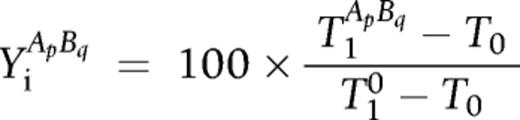

where ${T_0}$ is the time zero endpoint measurement, $T_1^{{A_p}{B_q}}$ is the endpoint measurement after 2 days, and $T_1^0$ is the endpoint measurement after 2 days for the control well. Define $Y_i^{A_p}$; $Y_i^{B_q}$ as the growth fractions when only exposed to drug A or drug B, respectively. The expected growth fraction for the combination is:

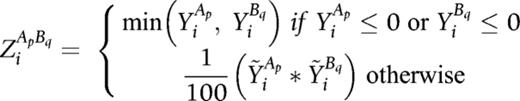

where ${\tilde Y_i} = \min ( {{Y_i},\;100} )$ truncates the growth fraction at 100. The final combination score for the cell line and the drug combination is the sum of the differences in expected versus observed growth fractions:

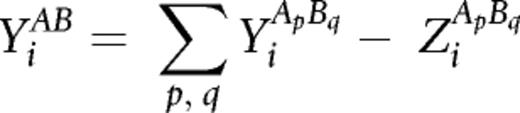

In [19]:
# Load the Combo Score file:

import pandas as pd

# Path to your text file
txt_file_path = "/nfs/turbo/med-kayvan-lab/Projects/DrugCombination/b-DrugCombination/DC_Data/NCI60-DTP_ALMANAC/data_NCI60-DTP Almanac_act.txt"

# Read the text file into a DataFrame
df = pd.read_csv(txt_file_path, delimiter='\t')

# Display the DataFrame
print(df.info())
print(df.head())
print(df.tail())

# Save the DataFrame to a CSV file
df.to_csv('ComboScore.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5355 entries, 0 to 5354
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               5355 non-null   object 
 1   NAME             5355 non-null   object 
 2   MOA              5355 non-null   object 
 3   CLINICAL.STATUS  5355 non-null   object 
 4   BR:MCF7          5309 non-null   float64
 5   BR:MDA-MB-231    5300 non-null   float64
 6   BR:HS 578T       5226 non-null   float64
 7   BR:BT-549        5247 non-null   float64
 8   BR:T-47D         5218 non-null   float64
 9   CNS:SF-268       5303 non-null   float64
 10  CNS:SF-295       5123 non-null   float64
 11  CNS:SF-539       5189 non-null   float64
 12  CNS:SNB-19       5297 non-null   float64
 13  CNS:SNB-75       5062 non-null   float64
 14  CNS:U251         5280 non-null   float64
 15  CO:COLO 205      5224 non-null   float64
 16  CO:HCC-2998      5156 non-null   float64
 17  CO:HCT-116    